In [99]:
import numpy as np
import pandas as pd
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn

from code.utils.settings import DefaultPath

In [5]:
stat_2coll =        pd.read_csv(DefaultPath.data_path.wikitables + 'double_collection_v1.csv')

stat_1coll_v1 =        pd.read_csv(DefaultPath.data_path.wikitables + 'single_collection_v1.csv')
stat_1coll_v2 =        pd.read_csv(DefaultPath.data_path.wikitables + 'single_collection_v2.csv')

In [6]:
stat_2coll

,id_test,vector_size,n_tables,n_tables (% sloth_tables),n_tables (% train_tables),total processed embeddings,batch_size,add_label,remobe_numbers,with_metadatas,preprocessing time (s),preprocessing time (%),storing time (s),storing time (%),total time (s),db size (GB),index size (GB),db-over-index size fraction,batch processing timestep
0,0,300,100,0.08842,0.01754,1748,100,0,0,0,1.63935,47.45512,1.81518,52.54488,3.45453,0.00279,0.00273,1.02386,[]
1,1,300,100,0.08842,0.01754,1748,100,1,0,0,2.08366,56.02345,1.63561,43.97655,3.71927,0.00279,0.00273,1.02386,[]
2,4,300,250,0.22105,0.04385,4665,250,0,0,0,3.75550,47.10383,4.21731,52.89617,7.97280,0.00723,0.00415,1.74093,[]
3,5,300,250,0.22105,0.04385,4665,250,1,0,0,6.81835,58.75964,4.78545,41.24036,11.60381,0.00724,0.00415,1.74191,[]
4,8,300,500,0.44209,0.08769,8781,500,0,0,0,6.91497,50.39229,6.80731,49.60771,13.72228,0.01350,0.01109,1.21800,[]
5,9,300,500,0.44209,0.08769,8781,500,1,0,0,8.57142,56.11914,6.70219,43.88086,15.27361,0.01350,0.01109,1.21800,[]
6,12,300,1000,0.88419,0.17539,17101,500,0,0,0,13.06599,46.70023,14.91244,53.29977,27.97842,0.02617,0.02218,1.17976,[]
7,13,300,1000,0.88419,0.17539,17101,500,1,0,0,16.32857,46.03755,19.13936,53.96245,35.46793,0.02616,0.02218,1.17939,[]
8,14,300,1000,0.88419,0.17539,17101,1000,0,0,0,15.13847,49.61456,15.37368,50.38544,30.51216,0.02616,0.02218,1.17939,[]
9,15,300,1000,0.88419,0.17539,17101,1000,1,0,0,16.42960,49.69912,16.62853,50.30088,33.05813,0.02616,0.02218,1.17939,[]


## Time Analyses

### Per-batch time processing

In [38]:
stat_batch = stat_2coll[stat_2coll['n_tables'] == 50000][['batch_size', 'total processed embeddings', 'add_label', 'with_metadatas', 'batch processing timestep']]
stat_batch['batch processing timestep'] = stat_batch['batch processing timestep'].apply(eval)
stat_batch

,batch_size,total processed embeddings,add_label,with_metadatas,batch processing timestep
26,500,842198,0,0,"[17.251, 13.749, 16.914, 14.098, 16.728, 21.43..."
27,500,842198,1,1,"[19.079, 18.02, 19.598, 25.348, 20.315, 29.954..."
28,2500,842198,0,0,"[69.854, 65.037, 68.977, 80.03, 73.652, 80.917..."
29,2500,842198,1,1,"[71.526, 83.455, 88.151, 90.077, 81.233, 87.51..."


In [28]:
timestep500 = stat_batch.loc[26]['batch processing timestep']
timestep2500 = stat_batch.loc[28]['batch processing timestep']
len(timestep500), len(timestep2500)

(100, 29)

In [56]:
mean_emb_per_batch500 = round(842198 / len(timestep500))
mean_emb_per_batch2500 = round(842198 / len(timestep2500))
mean_emb_per_batch500, mean_emb_per_batch2500

(8422, 29041)

In [30]:
mean_batch_time500 = sum(timestep500) / len(timestep500)
mean_batch_time2500 = sum(timestep2500) / len(timestep2500)
mean_batch_time500, mean_batch_time2500

(28.75499, 94.43348275862073)

In [32]:
embedding_per_sec500 = mean_emb_per_batch500 // mean_batch_time500
embedding_per_sec2500 = mean_emb_per_batch2500 // mean_batch_time2500
embedding_per_sec500, embedding_per_sec2500

(292.0, 307.0)

Does the batch processing time keep costant?

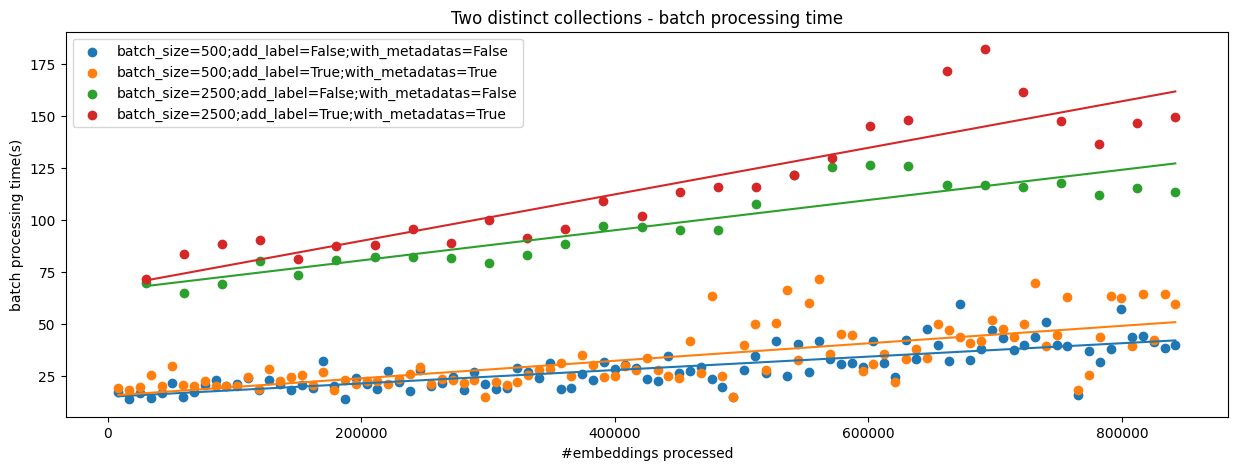

In [87]:
plt.figure(figsize=(15, 5))
plt.title('Two distinct collections - batch processing time')
plt.xlabel('#embeddings processed')
plt.ylabel('batch processing time(s)')
for i in range(26, 30):
    time_step = stat_batch.loc[i, 'batch processing timestep'][:-1]
    step = round(842198 // len(time_step))
    plt.scatter(
        range(step, 842198, step),
        time_step,
        label=f"batch_size={stat_batch.loc[i, 'batch_size']};add_label={bool(stat_batch.loc[i, 'add_label'])};with_metadatas={bool(stat_batch.loc[i, 'with_metadatas'])}"
        )
    m, b = np.polyfit(
        np.array(range(step, 842198, step)),
        time_step,
        1
    )
    plt.plot(np.array(range(step, 842198, step)), m * np.array(range(step, 842198, step)) + b)
plt.legend()

### Total processing time

In [97]:
stat_2coll

,id_test,vector_size,n_tables,n_tables (% sloth_tables),n_tables (% train_tables),total processed embeddings,batch_size,add_label,remobe_numbers,with_metadatas,preprocessing time (s),preprocessing time (%),storing time (s),storing time (%),total time (s),db size (GB),index size (GB),db-over-index size fraction,batch processing timestep
0,0,300,100,0.08842,0.01754,1748,100,0,0,0,1.63935,47.45512,1.81518,52.54488,3.45453,0.00279,0.00273,1.02386,[]
1,1,300,100,0.08842,0.01754,1748,100,1,0,0,2.08366,56.02345,1.63561,43.97655,3.71927,0.00279,0.00273,1.02386,[]
2,4,300,250,0.22105,0.04385,4665,250,0,0,0,3.75550,47.10383,4.21731,52.89617,7.97280,0.00723,0.00415,1.74093,[]
3,5,300,250,0.22105,0.04385,4665,250,1,0,0,6.81835,58.75964,4.78545,41.24036,11.60381,0.00724,0.00415,1.74191,[]
4,8,300,500,0.44209,0.08769,8781,500,0,0,0,6.91497,50.39229,6.80731,49.60771,13.72228,0.01350,0.01109,1.21800,[]
5,9,300,500,0.44209,0.08769,8781,500,1,0,0,8.57142,56.11914,6.70219,43.88086,15.27361,0.01350,0.01109,1.21800,[]
6,12,300,1000,0.88419,0.17539,17101,500,0,0,0,13.06599,46.70023,14.91244,53.29977,27.97842,0.02617,0.02218,1.17976,[]
7,13,300,1000,0.88419,0.17539,17101,500,1,0,0,16.32857,46.03755,19.13936,53.96245,35.46793,0.02616,0.02218,1.17939,[]
8,14,300,1000,0.88419,0.17539,17101,1000,0,0,0,15.13847,49.61456,15.37368,50.38544,30.51216,0.02616,0.02218,1.17939,[]
9,15,300,1000,0.88419,0.17539,17101,1000,1,0,0,16.42960,49.69912,16.62853,50.30088,33.05813,0.02616,0.02218,1.17939,[]


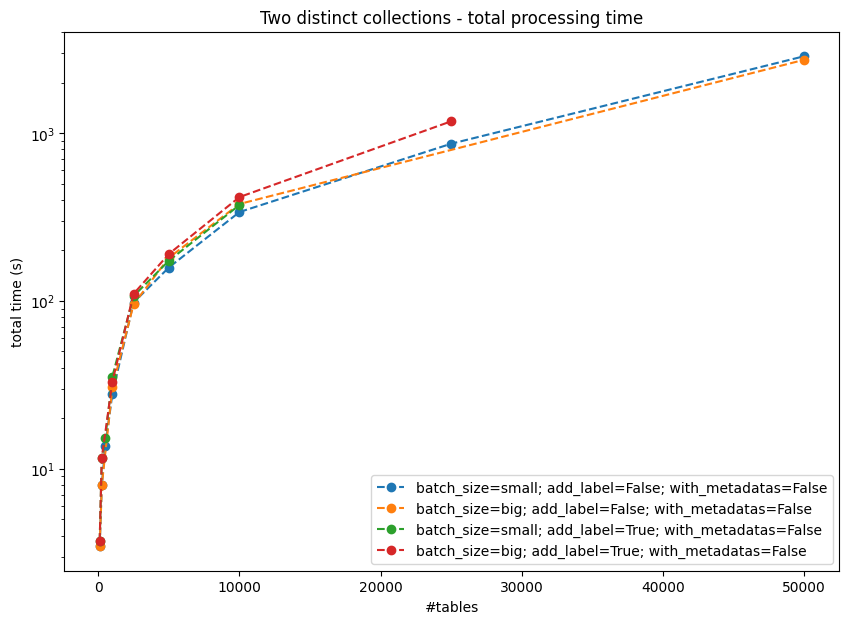

In [108]:
plt.figure(figsize=(10, 7))
plt.title('Two distinct collections - total processing time')
plt.ylabel('total time (s)')
plt.xlabel('#tables')
plt.yscale('log')

for add_label, batch_size in itertools.product((0, 1), ('small', 'big')):
    data = stat_2coll[(stat_2coll['add_label'] == add_label) \
                      & (stat_2coll['with_metadatas'] == 0) \
                      & ((stat_2coll['batch_size'] <= 500 if batch_size == 'small' else \
                          stat_2coll['batch_size'] != 500
                          )
                        )
                    ]

    plt.plot(
        data['n_tables'], 
        data['total time (s)'], 'o--',
        label=f"batch_size={batch_size}; add_label={bool(add_label)}; with_metadatas={bool(0)}")
plt.legend()

### Disk Space Analyses 

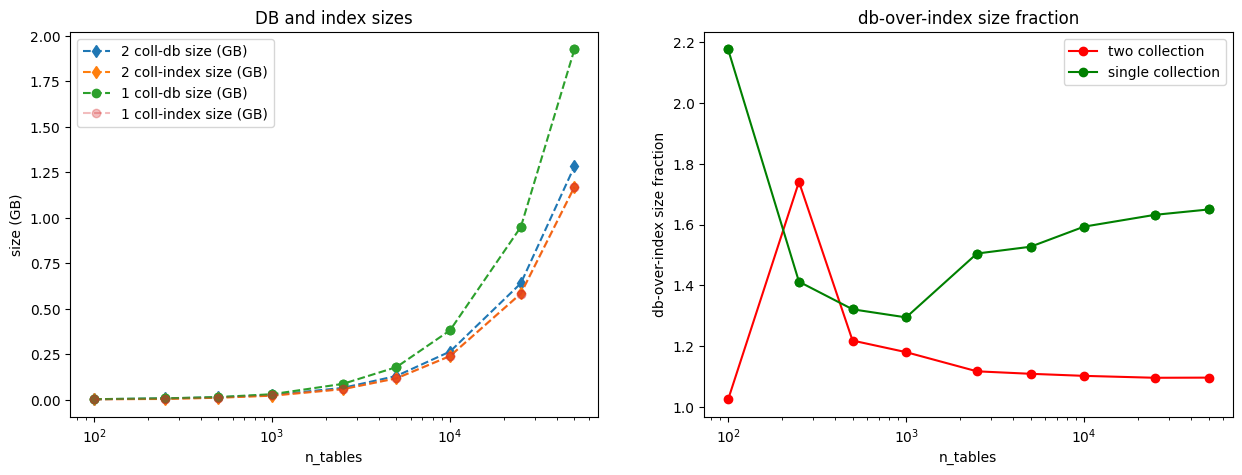

In [123]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
stat_2coll_data = stat_2coll[(stat_2coll['add_label'] == 0) & (stat_2coll['with_metadatas'] == 0) & (stat_2coll['batch_size'] <= 500)]

ax0.set_xscale('log')
ax0.plot(stat_2coll_data['n_tables'],   stat_2coll_data['db size (GB)'],      'd--', label='2 coll-db size (GB)')
ax0.plot(stat_2coll_data['n_tables'],   stat_2coll_data['index size (GB)'],   'd--', label='2 coll-index size (GB)')
ax0.plot(stat_1coll_v1['n_tables'],     stat_1coll_v1['db size (GB)'],      'o--', label='1 coll-db size (GB)')
ax0.plot(stat_1coll_v1['n_tables'],     stat_1coll_v1['index size (GB)'],   'o--', label='1 coll-index size (GB)', alpha=0.3)
ax0.set_xlabel('n_tables')
ax0.set_ylabel('size (GB)')
ax0.set_title('DB and index sizes')
ax0.legend()


ax1.set_xscale('log')
ax1.plot(stat_2coll_data['n_tables'], stat_2coll_data['db-over-index size fraction'], 'ro-', label='two collection')
ax1.plot(stat_1coll_v1['n_tables'], stat_1coll_v1['db-over-index size fraction'], 'go-', label='single collection')
ax1.set_xlabel('n_tables')
ax1.set_ylabel('db-over-index size fraction')
ax1.set_title('db-over-index size fraction')
ax1.legend()